In [1]:
import pandas as pd
import os
import datetime as dt
import numpy as np
from sklearn.impute import KNNImputer
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Marktstammdatenregisters

### Read data and combined


# Applied mask, grouped by Inbetriebnahmedatum and sum of values

In [2]:
def read_and_combine_files(start, end, folder_path):
    # Liste zum Speichern der eingelesenen DataFrames
    dfs = []

    # Durchlaufe den Bereich der Nummern
    for i in range(start, end + 1, 5000):
        # Erstelle den Dateinamen basierend auf dem Nummernbereich
        file_name = f"Stromerzeuger_{i}_bis_{i + 4999}.csv" 

        # Erstelle den vollständigen Pfad zur CSV-Datei
        file_path = os.path.join(folder_path, file_name)

        # Lese das CSV in einen DataFrame ein und füge ihn zur Liste hinzu
        df = pd.read_csv(file_path, delimiter=';')
        dfs.append(df)

    # Lese die letzte Datei ein
    last_file_path = os.path.join(folder_path, 'Stromerzeuger_465001_bis_465169.csv')
    last_df = pd.read_csv(last_file_path, delimiter=';')

    # Füge die letzte Datei zum DataFrame hinzu
    dfs.append(last_df)

    # Kombiniere alle DataFrames nach dem Index
    combined_df = pd.concat(dfs, axis=0, ignore_index=True)
    return combined_df

folder_path = r'C:\Users\mohdr\Portfolio project\Marktstammdatenregister'

combined_df = read_and_combine_files(1, 464999, folder_path)

combined_df.head()

,MaStR-Nr. der Einheit,Anzeige-Name der Einheit,Betriebs-Status,Inbetriebnahmedatum der Einheit,Registrierungsdatum der Einheit,Energieträger,Bruttoleistung der Einheit,Nettonennleistung der Einheit,Postleitzahl,Ort,Name des Anlagenbetreibers (nur Org.),\tMaStR-Nr. des Anlagenbetreibers,Letzte Aktualisierung
0,SEE945673330026,Haus,In Betrieb,2.2.2023,7.3.2024,Solare Strahlungsenergie,"9,84","9,84",92358,Seubersdorf,(natürliche Person),ABR972499841405,7.3.2024
1,SEE954126237928,Amsel_Power_2023,In Betrieb,19.4.2023,7.3.2024,Solare Strahlungsenergie,"7,8",6,85764,Oberschleißheim,(natürliche Person),ABR940716803345,7.3.2024
2,SEE989164765980,Garage,In Betrieb,18.12.2023,7.3.2024,Solare Strahlungsenergie,"3,4","3,4",85659,Forstern,(natürliche Person),ABR947782345816,7.3.2024
3,SEE920454310947,Axöd,In Betrieb,31.10.2023,7.3.2024,Solare Strahlungsenergie,"27,72",27,84307,Eggenfelden,(natürliche Person),ABR942303839591,7.3.2024
4,SEE908981253579,Solaranlage,In Betrieb,30.6.2023,7.3.2024,Solare Strahlungsenergie,"5,67","5,67",86167,Augsburg,(natürliche Person),ABR952078597961,7.3.2024


In [3]:
#selected_bruttoleistung = combined_df.groupby('Inbetriebnahmedatum der Einheit')['Bruttoleistung der Einheit'].apply(lambda x: x.str.replace(',', '.').astype(float).sum())

#print(selected_bruttoleistung)

In [16]:
# DataFrame mit Datum erstellen
df_combined = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2023', freq='1d')})

# Nur die Zeilen filtern, die den 'Betriebs-Status' 'In Betrieb' haben
mask_combined_df = (combined_df['Betriebs-Status'] == 'In Betrieb')
df_combined_filtered = combined_df.loc[mask_combined_df, :].copy()  # Kopie erstellen

# 'Inbetriebnahmedatum der Einheit' in Datumstyp konvertieren
df_combined_filtered['Inbetriebnahmedatum der Einheit'] = pd.to_datetime(df_combined_filtered['Inbetriebnahmedatum der Einheit'], format="%d.%m.%Y", errors='coerce')

# Gruppensummen für 'Bruttoleistung der Einheit' und 'Nettonennleistung der Einheit' basierend auf 'Inbetriebnahmedatum der Einheit' berechnen
grouped_sum = df_combined_filtered.groupby('Inbetriebnahmedatum der Einheit').agg({
    'Bruttoleistung der Einheit': lambda x: x.str.replace(',', '.').astype(float).sum(),
    'Nettonennleistung der Einheit': lambda x: x.str.replace(',', '.').astype(float).sum()
}).reset_index()

# Spaltennamen ändern
grouped_sum = grouped_sum.rename(columns={'Bruttoleistung der Einheit': 'Bruttoleistung', 'Nettonennleistung der Einheit': 'Nettoleistung'})

# Gruppensummen in den DataFrame df_combined einfügen
df_combined = df_combined.merge(grouped_sum, left_on='date', right_on='Inbetriebnahmedatum der Einheit', how='left').fillna(0)

# Ergebnisse anzeigen
df_combined = df_combined.drop(columns=['Inbetriebnahmedatum der Einheit'])  # Optional: Entfernen Sie die zusätzliche Spalte
print(df_combined)


           date  Bruttoleistung  Nettoleistung
0    2015-01-01         302.870        282.375
1    2015-01-02         926.050        782.540
2    2015-01-03          20.230         20.230
3    2015-01-04           0.000          0.000
4    2015-01-05         502.845        476.850
...         ...             ...            ...
3282 2023-12-27        3113.090       2748.850
3283 2023-12-28        2060.980       1782.245
3284 2023-12-29       13647.759      11110.429
3285 2023-12-30        1629.465       1302.568
3286 2023-12-31         301.775        263.300

[3287 rows x 3 columns]


# Bayern
### Tatsächliche und prognostizierte Solarenergieeinspeisung in der Regelzone von TenneT Deutschland - Bayern

In [5]:
# data source: https://netztransparenz.tennet.eu/de/strommarkt/transparenz/transparenz-deutschland/netzkennzahlen/tatsaechliche-und-prognostizierte-solarenergieeinspeisung/bayern/
# filtered for 2023-01-01 to 2023-12-31

df_en_raw = pd.read_table('solarEnergyFeedIn_BY_2015-01-01_2023-12-31.csv',sep=';',parse_dates=['Datum'],decimal=',')

df_en = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='12/31/2023', freq='1d')})

df_en.loc[:,'Prog_in_MW'] = pd.DataFrame(df_en_raw.groupby(['Datum'], as_index=False)['Prognostiziert in MW'].sum()).iloc[:,1]
df_en.loc[:,'Act_in_MW'] = pd.DataFrame(df_en_raw.groupby(['Datum'], as_index=False)['Tatsaechlich in MW'].sum()).iloc[:,1]

#df = df.merge(df_en,on='date')
#df_en

In [6]:
df_en_com = pd.merge(df_combined,df_en, on = 'date')
df_en_com = pd.DataFrame(df_en_com)
df_en_com.head()

,date,Bruttoleistung,Nettoleistung,Prog_in_MW,Act_in_MW
0,2015-01-01,302.870,282.375,0.0,2807.7
1,2015-01-02,926.050,782.540,0.0,2813.0
2,2015-01-03,20.230,20.230,0.0,6713.3
3,2015-01-04,0.000,0.000,13422.3,4321.5
4,2015-01-05,502.845,476.850,18801.3,20532.6


# Stationsmessungen der Solarstrahlung

tageswerte_ST_03668, 05792, 05856, 05705 und 02290 \\
07370 und 00867 Started 2021 and 05404 Ended 2014, therefore these stations are excluded

In [7]:
df = pd.DataFrame({'date': pd.date_range(start='1/1/2015', end='31/12/2023', freq='1d')})
#'07370' Started 2021, '05404' Ended 2014 and '00867 Started 2021', therefore these stations are excluded

stationsid = ['03668', '05792', '05856', '05705', '02290', '05404']

for id in stationsid:
    stationsname = f'stationid_{id}.txt'
    
    # Construct the full path to the station file within the 'Station' folder
    station_path = os.path.abspath(os.path.join(os.getcwd(), 'Stations', stationsname))
    
    df_stat = pd.read_csv(station_path, sep=';', parse_dates=['MESS_DATUM'], usecols=['MESS_DATUM', 'FD_STRAHL', 'FG_STRAHL', 'SD_STRAHL'])
    
    mask = (df_stat['MESS_DATUM'] >= '2015-01-01') & (df_stat['MESS_DATUM'] <= '2023-12-31')
    
    df_stat.columns = ['date', f'{id}_FD_STRAHL', f'{id}_FG_STRAHL', f'{id}_SD_STRAHL']
    
    # Merge based on the 'date' column
    df = df.merge(df_stat.loc[mask, :], on='date')
df.head()

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,05705_FD_STRAHL,05705_FG_STRAHL,05705_SD_STRAHL,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL
0,2015-01-01,188.0,188.0,0.0,0.0,694.0,8.4,214.0,214.0,0.0,129.0,129.0,0.0,184.0,611.0,7.7,365.0,426.0,1.9
1,2015-01-02,76.0,76.0,0.0,0.0,383.0,2.8,251.0,259.0,0.1,62.0,62.0,0.0,320.0,414.0,2.6,233.0,281.0,2.0
2,2015-01-03,108.0,108.0,0.0,0.0,343.0,1.2,297.0,316.0,0.3,92.0,92.0,0.0,253.0,265.0,0.8,194.0,196.0,0.0
3,2015-01-04,232.0,233.0,0.0,0.0,252.0,0.0,206.0,207.0,0.0,195.0,196.0,0.0,252.0,274.0,1.0,182.0,183.0,0.0
4,2015-01-05,157.0,485.0,6.2,0.0,591.0,2.9,223.0,223.0,0.0,129.0,502.0,7.5,279.0,457.0,3.5,344.0,392.0,1.8


# Final Combination DataFrame from 3 Tables

In [8]:
df_final = df.merge(df_en_com, on = 'date')
df_final.head()

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Prog_in_MW,Act_in_MW
0,2015-01-01,188.0,188.0,0.0,0.0,694.0,8.4,214.0,214.0,0.0,...,184.0,611.0,7.7,365.0,426.0,1.9,302.870,282.375,0.0,2807.7
1,2015-01-02,76.0,76.0,0.0,0.0,383.0,2.8,251.0,259.0,0.1,...,320.0,414.0,2.6,233.0,281.0,2.0,926.050,782.540,0.0,2813.0
2,2015-01-03,108.0,108.0,0.0,0.0,343.0,1.2,297.0,316.0,0.3,...,253.0,265.0,0.8,194.0,196.0,0.0,20.230,20.230,0.0,6713.3
3,2015-01-04,232.0,233.0,0.0,0.0,252.0,0.0,206.0,207.0,0.0,...,252.0,274.0,1.0,182.0,183.0,0.0,0.000,0.000,13422.3,4321.5
4,2015-01-05,157.0,485.0,6.2,0.0,591.0,2.9,223.0,223.0,0.0,...,279.0,457.0,3.5,344.0,392.0,1.8,502.845,476.850,18801.3,20532.6


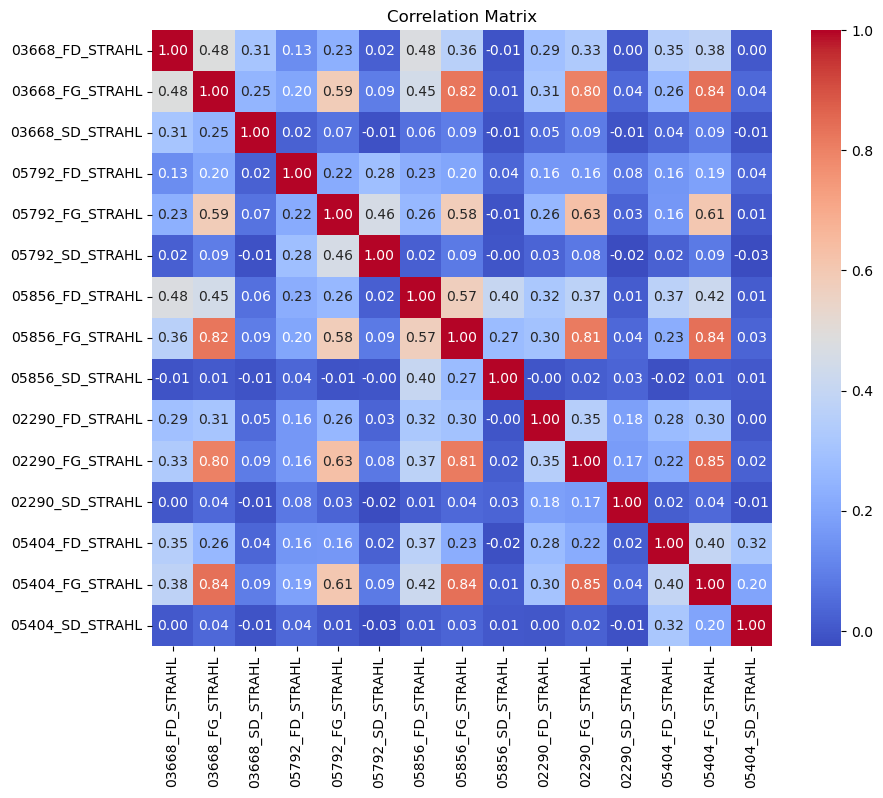

In [9]:
usecol = ['03668_FD_STRAHL','03668_FG_STRAHL','03668_SD_STRAHL','05792_FD_STRAHL','05792_FG_STRAHL','05792_SD_STRAHL',
          '05856_FD_STRAHL','05856_FG_STRAHL','05856_SD_STRAHL','02290_FD_STRAHL','02290_FG_STRAHL','02290_SD_STRAHL',
          '05404_FD_STRAHL','05404_FG_STRAHL','05404_SD_STRAHL']
subset = df_final[usecol]
correlation_matrix = subset.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
#df_final.isnull().sum()

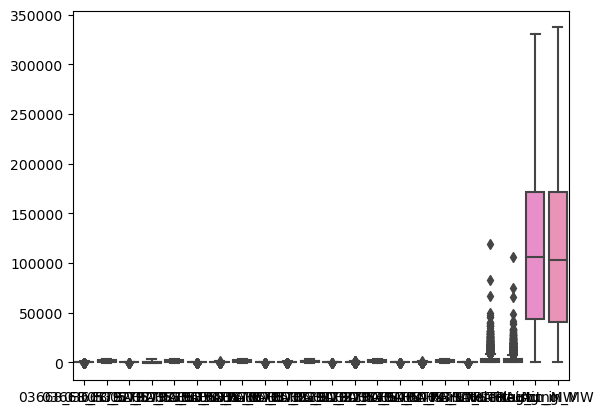

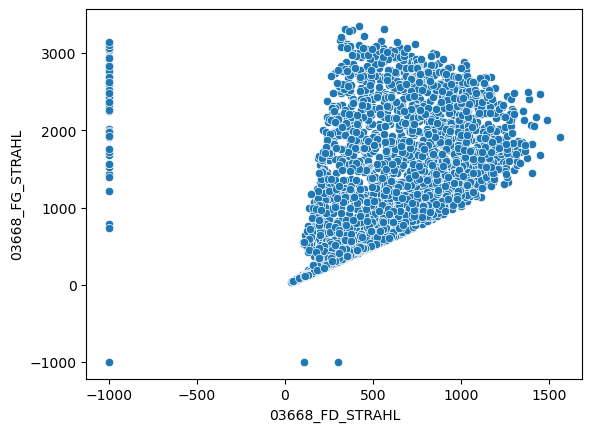

In [10]:
sns.boxplot(data=df_final)
plt.show()

# Scatter plot for outlier detection
sns.scatterplot(x='03668_FD_STRAHL', y='03668_FG_STRAHL', data=df_final)
plt.show()

In [17]:
df_final.to_csv('df_final_raw_2015_2023.csv')